In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import string

from tensorflow.keras import layers
from tensorflow.keras import losses

# requires update to tensorflow 2.4
# >>> conda activate PIC16B
# >>> pip install tensorflow==2.4
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers.experimental.preprocessing import StringLookup

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
import sqlite3

def retrieve(word):
    '''
    queries recipe database for titles including a specified word
    Parameters:
        word (str): keyword for parsing the recipe data
    Returns:
        pandas DataFrame with relevant recipes
    '''
    
    with sqlite3.connect("recipes1M.db") as conn:
        cmd = \
        f"""
        SELECT R.title
        FROM recipes R
        WHERE R.title LIKE "%{word}%"
        """
        df = pd.read_sql_query(cmd, conn)
    
    return df

In [3]:
df = retrieve("salmon")
df

,title
0,Salmon & Salad a La SPORTZ
1,Curried Pumpkin and Smoked Salmon Soup
2,Grilled Rosemary Salmon Spedini
3,Garlic and Dill Salmon
4,Spicy Grilled Orange Salmon
...,...
10788,Creamy Smoked Salmon and Dill Frittata
10789,Salmon and Spaghetti Casserole
10790,Salmon Pot Pie
10791,Pesto-Crusted Salmon Fillet With Citrus-Soy Sauce


In [4]:
data_raw = df.values.tolist()
data_str = [item for recipe in data_raw for item in recipe]

In [5]:
max_len = 100
data_ftr = [recipe_text for recipe_text in data_str if len(recipe_text) <= max_len]
len(data_ftr)

10770

The following code was taken from this website: https://www.kdnuggets.com/2020/07/generating-cooking-recipes-using-tensorflow.html. It is a blog post by Oleksii Trekhleb.

In [6]:
STOP_SIGN = '␣'

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    char_level=True,
    filters='',
    lower=False,
    split=''
)

# Stop word is not a part of recipes, but tokenizer must know about it as well.
tokenizer.fit_on_texts([STOP_SIGN])

tokenizer.fit_on_texts(data_ftr)

tokenizer.get_config()

{'num_words': None,
 'filters': '',
 'lower': False,
 'split': '',
 'char_level': True,
 'oov_token': None,
 'document_count': 10771,
 'word_counts': '{"\\u2423": 1, "S": 18252, "a": 33966, "l": 21766, "m": 16103, "o": 23237, "n": 21950, " ": 42005, "&": 406, "d": 12250, "L": 1273, "P": 3221, "O": 815, "R": 2000, "T": 1443, "Z": 66, "C": 4561, "u": 6498, "r": 13158, "i": 17036, "e": 27059, "p": 4059, "k": 4401, "G": 2337, "s": 10736, "y": 2653, "c": 6133, "D": 1032, "g": 2850, "t": 13315, "W": 2569, "h": 7799, "b": 1768, "B": 3081, "w": 3362, ",": 739, "M": 1805, "N": 289, "v": 992, "f": 1157, "U": 52, "\'": 418, "E": 581, "F": 1370, "z": 919, "(": 276, "3": 8, "I": 261, ")": 268, "V": 391, "H": 954, "j": 149, "/": 105, "x": 105, ".": 70, "A": 1291, "Q": 252, "-": 1927, "\\"": 81, "Y": 116, "J": 161, "q": 188, "K": 193, "!": 62, "[": 1, "]": 1, "#": 18, "5": 22, "X": 9, "8": 1, "4": 5, "*": 10, ":": 32, "9": 1, "1": 17, "0": 14, "7": 3, "2": 24, "?": 1, "=": 1, "_": 1, "6": 1, ";": 1, 

In [7]:
VOCABULARY_SIZE = len(tokenizer.word_counts) + 1

print('VOCABULARY_SIZE: ', VOCABULARY_SIZE)

VOCABULARY_SIZE:  85


In [8]:
print(tokenizer.index_word[5])
print(tokenizer.index_word[20])

n
w


In [9]:
tokenizer.word_index['r']

11

In [10]:
data_vec = tokenizer.texts_to_sequences(data_ftr)
print('Vectorized dataset size', len(data_vec)) 

Vectorized dataset size 10770


In [11]:
print(data_vec[0][:10], '...')

[7, 2, 6, 9, 4, 5, 1, 44, 1, 7] ...


In [12]:
def recipe_sequence_to_string(recipe_sequence):
    recipe_stringified = tokenizer.sequences_to_texts([recipe_sequence])[0]
    print(recipe_stringified)

recipe_sequence_to_string(data_vec[110])

P a s t a   W i t h   R e d   S a u c e   a n d   S a l m o n


In [13]:
dataset_vectorized_padded_without_stops = tf.keras.preprocessing.sequence.pad_sequences(
    data_vec,
    padding='post',
    truncating='post',
    # We use -1 here and +1 in the next step to make sure
    # that all recipes will have at least 1 stops sign at the end,
    # since each sequence will be shifted and truncated afterwards
    # (to generate X and Y sequences).
    maxlen=max_len-1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)

dataset_vectorized_padded = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized_padded_without_stops,
    padding='post',
    truncating='post',
    maxlen=max_len+1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)

for recipe_index, recipe in enumerate(dataset_vectorized_padded[:10]):
    print('Recipe #{} length: {}'.format(recipe_index, len(recipe)))

Recipe #0 length: 101
Recipe #1 length: 101
Recipe #2 length: 101
Recipe #3 length: 101
Recipe #4 length: 101
Recipe #5 length: 101
Recipe #6 length: 101
Recipe #7 length: 101
Recipe #8 length: 101
Recipe #9 length: 101


In [14]:
recipe_sequence_to_string(dataset_vectorized_padded[0])

S a l m o n   &   S a l a d   a   L a   S P O R T Z ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣


In [15]:
dataset = tf.data.Dataset.from_tensor_slices(dataset_vectorized_padded)

print(dataset)

<TensorSliceDataset shapes: (101,), types: tf.int32>


In [16]:
for recipe in dataset.take(1):
    print('Raw recipe:\n', recipe.numpy(), '\n\n\n')
    print('Stringified recipe:\n')
    recipe_sequence_to_string(recipe.numpy())

Raw recipe:
 [ 7  2  6  9  4  5  1 44  1  7  2  6  2 12  1  2  1 34  2  1  7 21 40 27
 31 60 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74
 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74
 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74
 74 74 74 74 74] 



Stringified recipe:

S a l m o n   &   S a l a d   a   L a   S P O R T Z ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣


In [17]:
def split_input_target(recipe):
    input_text = recipe[:-1]
    target_text = recipe[1:]
    
    return input_text, target_text

dataset_targeted = dataset.map(split_input_target)

print(dataset_targeted)

<MapDataset shapes: ((100,), (100,)), types: (tf.int32, tf.int32)>


In [18]:
for input_example, target_example in dataset_targeted.take(1):
    print('Input sequence size:', repr(len(input_example.numpy())))
    print('Target sequence size:', repr(len(target_example.numpy())))
    print()
    
    input_stringified = tokenizer.sequences_to_texts([input_example.numpy()[:50]])[0]
    target_stringified = tokenizer.sequences_to_texts([target_example.numpy()[:50]])[0]
    
    print('Input:  ', repr(''.join(input_stringified)))
    print('Target: ', repr(''.join(target_stringified))) 

Input sequence size: 100
Target sequence size: 100

Input:   'S a l m o n   &   S a l a d   a   L a   S P O R T Z ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣'
Target:  'a l m o n   &   S a l a d   a   L a   S P O R T Z ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣'


In [19]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:10], target_example[:10])):
    print('Step {:2d}'.format(i + 1))
    print('  input: {} ({:s})'.format(input_idx, repr(tokenizer.sequences_to_texts([[input_idx.numpy()]])[0])))
    print('  expected output: {} ({:s})'.format(target_idx, repr(tokenizer.sequences_to_texts([[target_idx.numpy()]])[0])))

Step  1
  input: 7 ('S')
  expected output: 2 ('a')
Step  2
  input: 2 ('a')
  expected output: 6 ('l')
Step  3
  input: 6 ('l')
  expected output: 9 ('m')
Step  4
  input: 9 ('m')
  expected output: 4 ('o')
Step  5
  input: 4 ('o')
  expected output: 5 ('n')
Step  6
  input: 5 ('n')
  expected output: 1 (' ')
Step  7
  input: 1 (' ')
  expected output: 44 ('&')
Step  8
  input: 44 ('&')
  expected output: 1 (' ')
Step  9
  input: 1 (' ')
  expected output: 7 ('S')
Step 10
  input: 7 ('S')
  expected output: 2 ('a')


In [20]:
print(dataset_targeted)

<MapDataset shapes: ((100,), (100,)), types: (tf.int32, tf.int32)>


In [21]:
# Batch size.
BATCH_SIZE = 64

# Buffer size to shuffle the dataset (TF data is designed to work
# with possibly infinite sequences, so it doesn't attempt to shuffle
# the entire sequence in memory. Instead, it maintains a buffer in
# which it shuffles elements).
SHUFFLE_BUFFER_SIZE = 1000

dataset_train = dataset_targeted.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).repeat()

print(dataset_train)

<RepeatDataset shapes: ((64, 100), (64, 100)), types: (tf.int32, tf.int32)>


In [22]:
for input_text, target_text in dataset_train.take(1):
    print('1st batch: input_text:', input_text)
    print()
    print('1st batch: target_text:', target_text)


1st batch: input_text: tf.Tensor(
[[17 11  2 ... 74 74 74]
 [ 7  9  4 ... 74 74 74]
 [ 7  6  4 ... 74 74 74]
 ...
 [21  3 16 ... 74 74 74]
 [46  3 20 ... 74 74 74]
 [34  3  9 ... 74 74 74]], shape=(64, 100), dtype=int32)

1st batch: target_text: tf.Tensor(
[[11  2 30 ... 74 74 74]
 [ 9  4 18 ... 74 74 74]
 [ 6  4 20 ... 74 74 74]
 ...
 [ 3 16  2 ... 74 74 74]
 [ 3 20 16 ... 74 74 74]
 [ 3  9  4 ... 74 74 74]], shape=(64, 100), dtype=int32)


In [23]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        batch_input_shape=[batch_size, None]
    ))

    model.add(tf.keras.layers.LSTM(
        units=rnn_units,
        return_sequences=True,
        stateful=True,
        recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocab_size))
    
    return model

model = build_model(
  vocab_size=VOCABULARY_SIZE,
  embedding_dim=256,
  rnn_units=1024,
  batch_size=BATCH_SIZE
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           21760     
_________________________________________________________________
lstm (LSTM)                  (64, None, 1024)          5246976   
_________________________________________________________________
dense (Dense)                (64, None, 85)            87125     
Total params: 5,355,861
Trainable params: 5,355,861
Non-trainable params: 0
_________________________________________________________________


In [24]:
# An objective function.
# The function is any callable with the signature scalar_loss = fn(y_true, y_pred).
def loss(labels, logits):
    entropy = tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )
    
    return entropy

In [25]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=adam_optimizer,
    loss=loss
)


In [26]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='loss',
    restore_best_weights=True,
    verbose=1
)


In [36]:
# Create a checkpoints directory.
import os
checkpoint_dir = 'tmp/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)


In [40]:
EPOCHS = 5
INITIAL_EPOCH = 1
STEPS_PER_EPOCH = 10

history = model.fit(
    x=dataset_train,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    initial_epoch=INITIAL_EPOCH,
    callbacks=[
        checkpoint_callback,
        early_stopping_callback
    ]
)

# Saving the trained model to file (to be able to re-use it later).
model_name = 'recipe_generation_rnn_raw.h5'
model.save(model_name, save_format='h5')

# def render_training_history(training_history):
#     loss = training_history.history['loss']

#     plt.title('Loss')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.plot(loss, label='Training set')
#     plt.legend()
#     plt.grid(linestyle='--', linewidth=1, alpha=0.5)
#     plt.show()

# render_training_history(history)

Epoch 2/5
10/10 [==============================] - 30s 3s/step - loss: 1.0494
Epoch 3/5
10/10 [==============================] - 32s 3s/step - loss: 0.9935
Epoch 4/5
10/10 [==============================] - 33s 3s/step - loss: 1.0437
Epoch 5/5
10/10 [==============================] - 33s 3s/step - loss: 0.9877


OSError: Unable to create file (unable to truncate a file which is already open)

In [34]:
import h5py

history = h5py.File('recipe_generation_rnn_raw.h5', 'r')
history

<HDF5 file "recipe_generation_rnn_raw.h5" (mode r)>

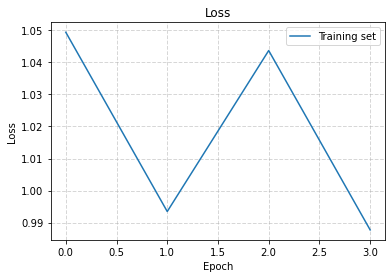

In [41]:
from matplotlib import pyplot as plt

def render_training_history(training_history):
    loss = training_history.history['loss']

    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

render_training_history(history)

In [42]:
tf.train.latest_checkpoint(checkpoint_dir)
#print(checkpoint_dir)

'tmp/checkpoints\\ckpt_5'

In [43]:
simplified_batch_size = 1

model_simplified = build_model(VOCABULARY_SIZE, embedding_dim = 256, rnn_units = 1024, batch_size =simplified_batch_size)
model_simplified.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model_simplified.build(tf.TensorShape([simplified_batch_size, None]))

model_simplified.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 256)            21760     
_________________________________________________________________
lstm_1 (LSTM)                (1, None, 1024)           5246976   
_________________________________________________________________
dense_1 (Dense)              (1, None, 85)             87125     
Total params: 5,355,861
Trainable params: 5,355,861
Non-trainable params: 0
_________________________________________________________________


In [47]:
model_simplified.input_shape

(1, None)

In [44]:
def generate_text(model, start_string, num_generate = 1000, temperature=1.0):
    # Evaluation step (generating text using the learned model)
    
    padded_start_string = STOP_SIGN + start_string

    # Converting our start string to numbers (vectorizing).
    input_indices = np.array(tokenizer.texts_to_sequences([padded_start_string]))

    # Empty string to store our results.
    text_generated = []

    # Here batch size == 1.
    model.reset_states()
    for char_index in range(num_generate):
        predictions = model(input_indices)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model.
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(
            predictions,
            num_samples=1
        )[-1, 0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)
        
        next_character = tokenizer.sequences_to_texts(input_indices.numpy())[0]

        text_generated.append(next_character)

    return (padded_start_string + ''.join(text_generated))

In [45]:
def generate_combinations(model):
    recipe_length = 1000
    try_letters = ['', '\n', 'A', 'B', 'C', 'O', 'L', 'Mushroom', 'Apple', 'Slow', 'Christmass', 'The', 'Banana', 'Homemade']
    try_temperature = [1.0, 0.8, 0.4, 0.2]

    for letter in try_letters:
        for temperature in try_temperature:
            generated_text = generate_text(
                model,
                start_string=letter,
                num_generate = recipe_length,
                temperature=temperature
            )
            print(f'Attempt: "{letter}" + {temperature}')
            print('-----------------------------------')
            print(generated_text)
            print('\n\n')


In [48]:
generate_combinations(model_simplified)

Attempt: "" + 1.0
-----------------------------------
␣XTd_RmPoAae*hcWiootees␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣rr␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣s␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣mRoop ralnostMt oetldhaed iFtsWlstatlga e tate tttT nteeiph-toos␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣orln o nddiSannkprs urrlaplm-s Hhracat-uablo sw lceas␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣

Attempt: "A" + 1.0
-----------------------------------
␣AQ&-dvpoxH5==_99N*:=X9*J*]4J5[=_?X3?Y0"0]*X43*Z07?`_1963J0Xqx__U`U8;6[J05#2[7QxJ.0X1?44X]]:?95*.`J7U3_00:6X94X]Z9_9KJ:95`8?]9Z]]?:2]?7;#:qZ7I_J=6Y:]9_6?x;6]646!]U45][_]X3j02X?_0][q90#?:4_].14[[J0_Y`JJ98`ZU4[59Z;]099J9Zx]]3j9J2946X!363[=2`X_]_Z21]`[`1j1!1[0XJ3[Z70[7=601][!74`]N]x?5:9001_:]XX?6U[1_]#]J:X70Z60.J0]]6_X8*Z8q?441XQU1!U8.X7N]26[_[q70_V4J8]]5993`[]`X[3?`U50##92j[(6J6[309_9..003[_2=#0[2Z9049?x8Z0692]X4`)1=4=:3`9!?2"7]q5`769][3"1?97596q*]`"_``8[59x]9J3X;]Z/41`016!Q9`54U;&=!`x2V9]6]_!79?J]37`0:q]=8402993.#N"j40j`[`[4_9=J3?0x6jX0E5#*&``059!=?99`3936!q22=9[!.03`=]5_58#03`0976X/X0J39[Xq]0``8[[X:X7[3:?X?3QQ4`9J[?]?]30:]#_9[!087=I9X0344Z*9X99Y:4`Y9`[?14)U!?:J76X:[4?89U910[.9]1;=07[;:I4`#`I9.`UK[5019&7*19][3??9`X9[Z?7"92*7:4Z_5`?[20I39`24)4_U_]?:690492[69*6]74?]_107J"5"6J32x8x:99]``O[X2U:"]5`"*1=X9X0`:'][`676]IJ574`9/R?X[6X2[=0044'K22X?;]q0![?`U`9JK8=qN33]3`3928776Y/2009`8)0U][909??7[][40"j?`qJXXX]3330?[85_8#8"J`X#64q22Z[9:;]2Jx9U

Attempt: "C" + 1.0
-----------------------------------
␣Cl3jAoEZ_h/1wAq0x#7.'9!`K#N0"0;21Zx0Z89=`00?x5]1/J#3V5]#"]#46J`]39760x]NK517z]XKU0)X18!4]]``9671"`90?]q6]=#994#=0`9#X]xq866[`]6!1][:[]8`[XZ7_9#[0!]47!419]43*J_6Z84;32&[.]V65J?#9.X#276_j83U3*6[09_]X`]`67=I#x967E]]Z939_?x)Z#[7X[5999X?[]00#[U"`]q]_96:4]b#J*!]"`.7422257#;2?967=0!8X*6081X3J04]]?!]97]07==010!_4109U4YIX2]X]1JZ?]`X04&__65*9_66J9]U]5159]V0j]6[=719#?I]`33X4"0]];]87]=JI7"40?U"3;_499_536#!K6?68#Y#Jj=xZ49Z4#]07]U]89x[][_[x7[[7?278Q09_*9_69ZJ5`YZ`XU0[527Q?4`95]20_)90:JJ36#:`)x]`]4_X9X7::9X45J564[939]"`J=9]?/74*?0jx`;q9"7]799]696X43X79J*K6;09;/`X997Y][`093[.09#0[_6`!16`0#7]]0]?45[J.99]?6`.*JX]0]2*VN*Vx_`?]5?X79I`?`*_74?#9777??_09]NJJ3XJ9.[?]9]]9X157/95007`Q7[49[119xZ5:6X2207]!]9[O6[K692[]64`#!?Z3_J7xZ[=6ZY42j6_0;3_z]525]9[95]Z1X6879UJ`.4;2X;[Q_[J=__I]_X?=:!K=3XV9][J[]949?x9`0?7:_74[9[90NX/;7=70X?X:0:6]U3Xq!]2U:660JXX*)0770[_!6]9?9X[xA2];0]`JUJ`Xx_97#j94?7##56J19!._100!:[0`[J`10;J?9_]=7V]470?:3?j0#[;3Xj85_=??#6/`UX59:/U]03]:`7*57

Attempt: "L" + 1.0
-----------------------------------
␣LXe6zqonhdi Sr at s)␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣v␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣c␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣ee␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣

Attempt: "Apple" + 1.0
-----------------------------------
␣Applea  Ba0ndndLe asiWm-bn Wt seedoeee-Lari kaehe g sWwz␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣ia␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣ralkand lvcrhuHthwa rlG  mues chet h gnmoeuiLelrtcee␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣e␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣avln Sn␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣ coaoucz adi

Attempt: "Christmass" + 1.0
-----------------------------------
␣Christmass;␣ptilmRt etu␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣

Attempt: "Banana" + 1.0
-----------------------------------
␣Bananam7]B ZIZa-eyacdxh  doW i␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣r aln SoknpdtWohicophoe␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣e␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣

KeyboardInterrupt: 